In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from LEN_Scorer import Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import copy


In [2]:
mimicDF = pd.read_csv('../LEN_Test/data/StaticData.csv')
targetDF = mimicDF[['deathperiod']]
mimicDF = mimicDF.drop(columns=['PatientID', 'deathperiod'])

categorisationTypes = {}

In [3]:
mimicDF.head()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,NaN,0.0,3.0,3.0
1,2,0,75.00,4,2,NaN,0.0,0.0,1.0,NaN,1.0
2,16,0,51.92,4,2,NaN,0.0,NaN,0.0,NaN,2.0
3,12,0,51.73,-13,4,2.0,2.0,NaN,0.0,NaN,0.0
4,7,0,62.07,0,3,0.0,2.0,NaN,1.0,NaN,0.0


In [4]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,3311.000000,5227.000000,2254.000000,5261.000000,1294.000000,5212.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,1.987315,0.674957,0.696983,1.017297,3.238022,0.768611
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.374066,0.892066,1.051290,1.263514,0.706116,1.140061
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.000000,1.000000,1.000000,2.000000,4.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [5]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 4778 containing NaN values


In [6]:
for col in mimicDF:
    mimicDF[col] = mimicDF[col].fillna(mimicDF[col].mode()[0])

In [7]:
mimicDF['respiration'].mode()[0]

3.0

In [8]:
mimicDF

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,0.0,0.0,3.0,3.0
1,2,0,75.00,4,2,3.0,0.0,0.0,1.0,3.0,1.0
2,16,0,51.92,4,2,3.0,0.0,0.0,0.0,3.0,2.0
3,12,0,51.73,-13,4,2.0,2.0,0.0,0.0,3.0,0.0
4,7,0,62.07,0,3,0.0,2.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5257,120,1,36.61,5,10,3.0,3.0,4.0,0.0,3.0,0.0
5258,13,0,53.90,12,4,3.0,0.0,0.0,0.0,3.0,1.0
5259,4,0,58.93,18,5,3.0,1.0,0.0,4.0,3.0,0.0
5260,16,0,68.98,-4,3,1.0,2.0,0.0,0.0,3.0,0.0


In [9]:
for i in range(len(mimicDF['sofa'])):
    print(mimicDF['sofa'][i])

7
2
2
4
3
7
4
14
8
9
6
5
2
4
2
9
6
3
7
2
3
5
4
6
4
13
2
3
5
4
5
7
4
2
2
2
3
6
2
10
7
4
7
6
7
5
2
10
9
2
6
4
6
4
2
4
3
2
4
4
3
8
3
7
9
4
7
2
12
7
5
4
7
4
10
12
7
3
3
6
5
10
7
3
4
2
6
2
5
6
2
2
7
3
2
10
2
5
9
5
2
8
5
10
3
2
2
3
4
6
2
3
5
9
5
3
2
2
2
4
2
4
2
6
3
7
3
3
5
2
2
3
16
5
2
9
5
4
3
7
11
3
3
4
2
8
5
5
2
4
7
10
8
14
3
9
5
4
5
3
3
3
4
7
4
4
2
7
3
4
12
2
2
2
4
2
7
4
5
5
4
3
3
9
3
3
6
5
4
4
3
5
5
3
2
8
11
8
2
2
7
2
3
3
4
5
4
8
3
6
6
5
2
5
2
7
3
8
11
2
3
9
7
5
4
7
3
2
5
6
2
9
8
2
7
6
3
11
10
3
5
5
8
6
2
2
2
5
6
3
11
3
3
9
6
2
7
8
4
4
2
5
7
3
3
2
3
6
5
2
7
5
3
2
4
2
2
4
4
4
3
4
3
9
6
6
2
9
4
7
4
3
2
9
3
2
4
5
4
3
2
2
8
3
14
11
5
9
18
5
2
2
3
2
4
3
4
3
4
4
2
3
3
11
2
3
3
2
5
2
8
5
2
9
2
2
9
4
5
4
4
3
2
10
3
3
5
4
5
3
4
3
11
4
3
6
9
4
5
7
5
2
3
4
8
7
2
2
3
3
4
3
10
7
4
9
2
11
5
4
3
14
7
12
3
6
3
8
7
2
3
5
8
4
6
4
3
6
8
7
2
3
5
4
6
8
3
4
12
18
2
5
3
12
9
6
6
6
5
4
2
5
4
6
2
2
4
5
2
5
9
2
4
4
5
4
6
14
3
2
4
4
2
5
2
8
4
3
4
7
10
2
4
3
3
9
11
3
4
7
3
7
5
3
8
3
9
3
5
4
3
4
2
4
3
3
4
2
6
5
4
8


In [10]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.00000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,2.36279,0.670468,0.298556,1.017104,3.058533,0.761307
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.19465,0.890785,0.769595,1.263472,0.364759,1.137079
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,2.00000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,3.00000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.00000,1.000000,0.000000,2.000000,3.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000


In [11]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 0 containing NaN values


#### Replaced NaN values with average of respective columns

In [12]:
dataNeedingEncodingDF = mimicDF[['los', 'age', 'comorbidity', 'sofa']]

### Fixing high age range

In [13]:
ageWithoutOutliers = dataNeedingEncodingDF['age'][dataNeedingEncodingDF['age'] < 200]

dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))

dataNeedingEncodingDF.describe()

C:\Users\benma\AppData\Local\Temp/ipykernel_12864/3073677709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))


,los,age,comorbidity,sofa
count,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,64.805247,9.801026,4.794185
std,14.101457,15.710987,9.671438,2.694694
min,1.000000,16.010000,-16.000000,2.000000
25%,6.000000,54.795000,2.000000,3.000000
50%,10.000000,67.325000,9.000000,4.000000
75%,18.000000,77.315000,16.000000,6.000000
max,202.000000,89.000000,47.000000,22.000000


In [14]:
bins = 5

est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
kBinsDF = pd.DataFrame(data=est.fit_transform(dataNeedingEncodingDF), columns=dataNeedingEncodingDF.columns)

categorisationTypes['kBins'] = kBinsDF

In [15]:
agglomerativeDF = dataNeedingEncodingDF.apply(lambda x: AgglomerativeClustering(n_clusters=5).fit_predict(np.asarray(x).reshape(-1,1)))

categorisationTypes['Agglomerative'] = agglomerativeDF

In [16]:
kMeansDF = dataNeedingEncodingDF.apply(lambda x: KMeans(n_clusters=5, random_state=0).fit_predict(np.asarray(x).reshape(-1,1)))

categorisationTypes['KMeans'] = kMeansDF

# Graphically representing the categorisation

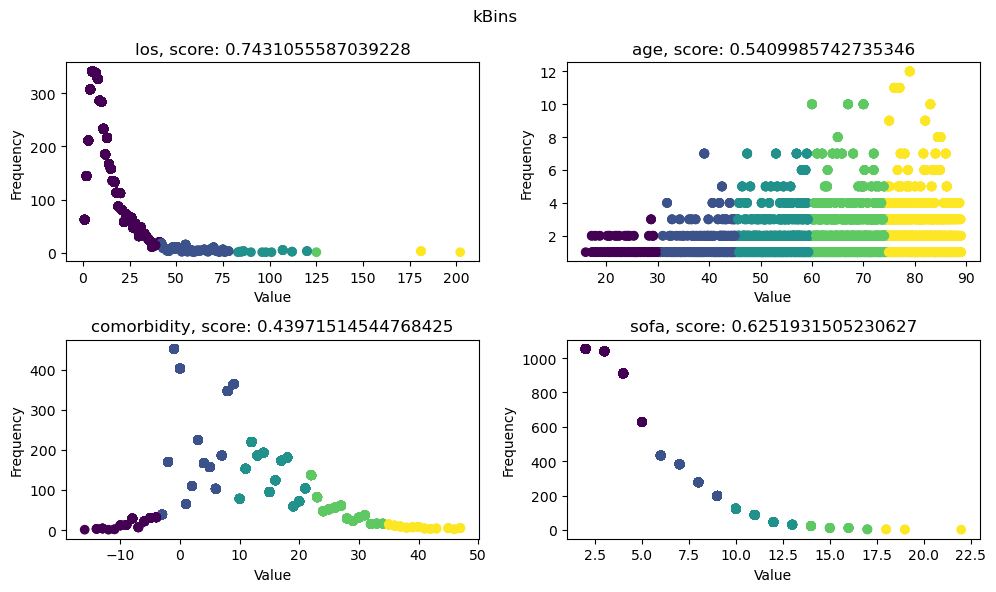

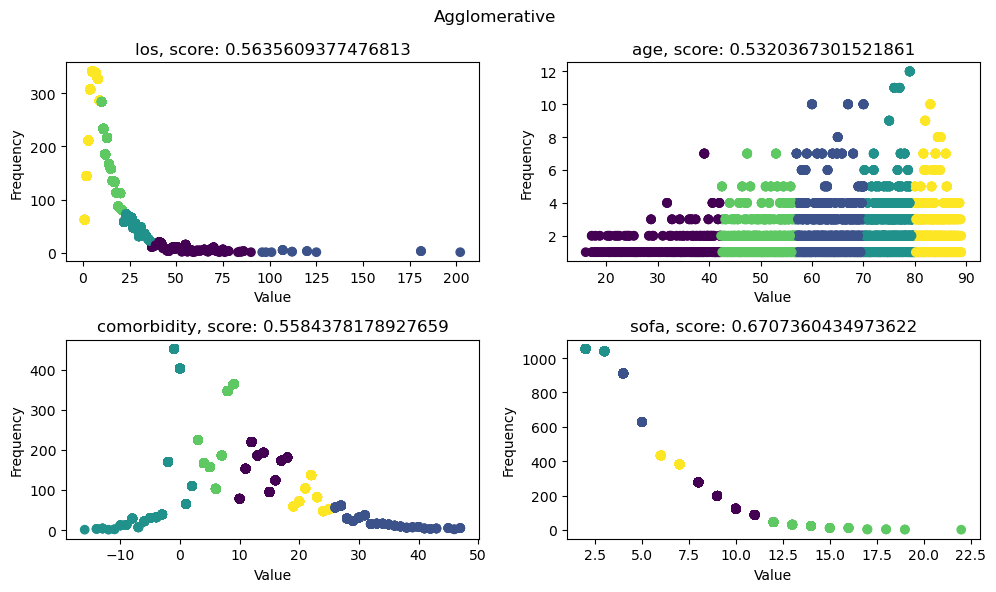

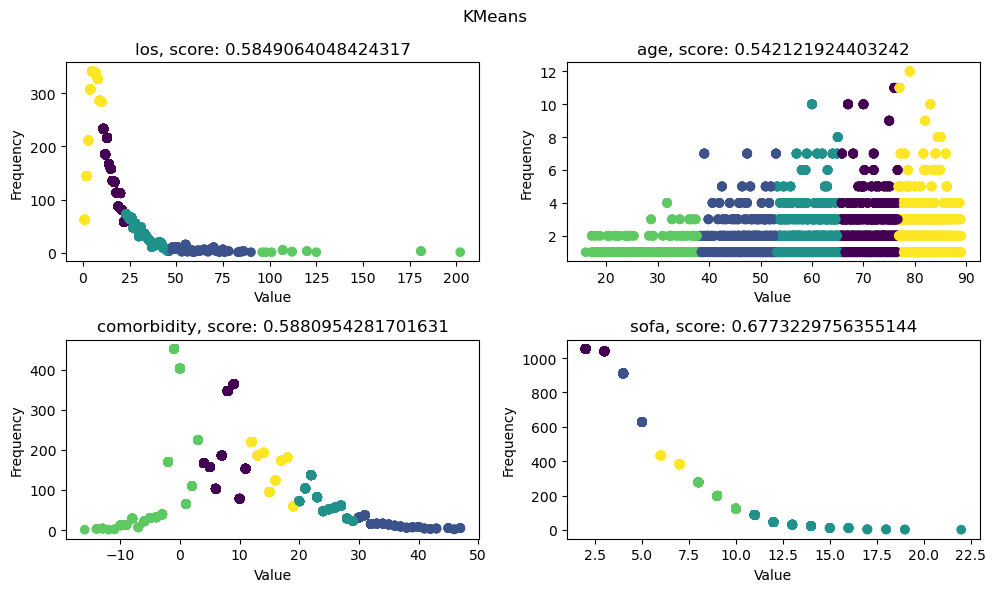

In [17]:
for type in categorisationTypes:

    df = categorisationTypes[type]

    fig = plt.figure(figsize=(10,6), dpi=100)

    fig.suptitle(f"{type}")

    for idx, col in enumerate(dataNeedingEncodingDF.columns):

        score = silhouette_score(np.asarray(dataNeedingEncodingDF[col]).reshape(-1,1), df[col])

        plt.subplot(2, 2, idx+1)
        plt.scatter(dataNeedingEncodingDF[col], dataNeedingEncodingDF[col].map(dataNeedingEncodingDF[col].value_counts()), c=df[col])
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.title(f"{col}, score: {score}")

    plt.tight_layout()
    plt.show()

In [18]:
pd.set_option('display.max_rows', 1000)

In [19]:
categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}


for type in categorisationTypes:

    categorisationTypes[type][['respiration','coagulation','liver','renal','cardiovascular','cns']] = mimicDF[['respiration','coagulation','liver','renal','cardiovascular','cns']]

    for col in categorisationTypes[type].columns:
        categorisationTypes[type][col] = categorisationTypes[type][col].map(categories)

    categorisationTypes[type]['gender'] = mimicDF['gender'].map({0:'male', 1:'female'})

    categorisationTypes[type] = pd.get_dummies(categorisationTypes[type])

    display(categorisationTypes[type])

,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5258,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5259,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
5260,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
5258,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5259,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5260,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5258,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5259,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
5260,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1


### TODO Do we want to standardise the data before categorising?

If another point (eg an outlier) is added to the dataset, then this could push the other points away from their original categorisation. Need outlier detection? 

In [20]:
targetDF.describe()

,deathperiod
count,5262.000000
mean,0.896047
std,7.338713
min,-29.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,107.000000


In [21]:
targetDF

,deathperiod
0,-1
1,2
2,-1
3,-1
4,-1
...,...
5257,-1
5258,-1
5259,-1
5260,-1


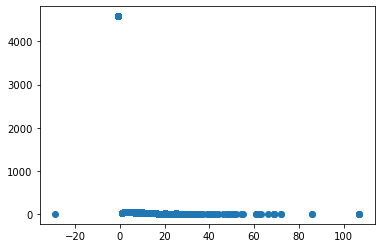

In [22]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()))
plt.show()

In [23]:
targetDF['deathperiod'] = targetDF['deathperiod'].apply(lambda x: x if x > -1 else -1)

In [24]:
targetDiedDF = targetDF[targetDF['deathperiod'] > -1]
targetNoDeathDF = targetDF[targetDF['deathperiod'] == -1].apply(lambda x: x+1.0)

In [25]:
targetDiedDF.shape

(678, 1)

In [26]:
targetNoDeathDF.shape

(4584, 1)

In [27]:
bins = 3

est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
targetCategorisedDF = pd.DataFrame(data=est.fit_transform(targetDiedDF), columns=['deathperiod'])

targetCategorisedDF['deathperiod'] = targetCategorisedDF['deathperiod'].apply(lambda x: x + 1)

targetCategorisedDF.set_index(targetDiedDF.index, inplace=True)

targetCategorisedDF.head()


,deathperiod
1,1.0
7,1.0
16,1.0
36,1.0
40,1.0


In [28]:
targetNoDeathDF.head()

,deathperiod
0,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [29]:
combinedTargetDF = pd.concat([targetCategorisedDF, targetNoDeathDF], axis=1)

withDeath = combinedTargetDF.iloc[:,0]
noDeath = combinedTargetDF.iloc[:,1]

newTargetDF = withDeath.fillna(noDeath)

newTargetDF = newTargetDF.astype(np.int64)

newTargetDF

0       0
1       1
2       0
3       0
4       0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
Name: deathperiod, Length: 5262, dtype: int64

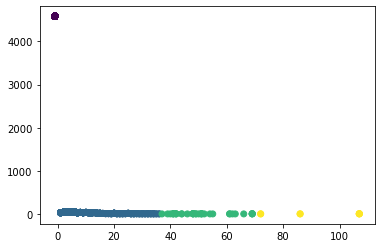

In [30]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()), c=newTargetDF)
plt.show()

### Here without the -1 value so we can see the variance of the rest

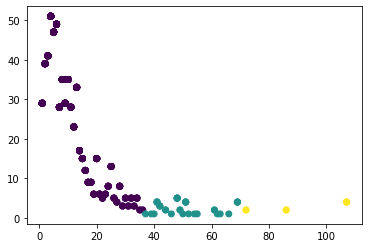

In [31]:
tempDF = targetDF[targetDF['deathperiod'] > -1]

plt.scatter(tempDF['deathperiod'], tempDF['deathperiod'].map(tempDF['deathperiod'].value_counts()), c=newTargetDF[newTargetDF> 0])
plt.show()

In [32]:
stackedTargetDF = np.stack(newTargetDF)

In [33]:
def score_classes(scorer, target_class):

    return scorer.explain(target_class)

In [107]:
class FOL:

    def __init__(self, features):
        self.features = features

    def __repr__(self):
        out = "("
        for i in range(len(self.features)):
            feature = self.features[i]
            if feature.sign == 'OR':
                out += ") \nOR \n("
                continue
            out += f"{feature}"
            if i+1 < len(self.features) and self.features[i+1].sign != 'OR':
                out += " AND "
        out += ")"
        return out


In [111]:
class Feature:

    def __init__(self, sign=None, number=None, name=None):
        self.sign = sign
        self.name = name
        self.number = number

    def __repr__(self):
        out = ""
        if self.sign is not None:
            if self.sign == -1:
                out += "NOT_"
            # out += f"{self.sign} "
        # if self.number is not None:
        #     out += f"{self.number} "
        if self.name is not None:
            out += f"{self.name}"
        return out

In [105]:
def convertFeaturesToColumnNames(explanation, columns):
    
    features = [x for x in explanation.split(" ") if x != '&']

    featureList = []

    for feature in features:
        f = Feature()
        if feature[0] == '|':
            f.sign = 'OR'
            featureList.append(f)
            continue
        if feature[-1] == ')':
            feature = feature[:-1]
        if feature[0] == '(':
            feature = feature[1:]
        if feature[0] == '~':
            f.sign = -1
        else:
            f.sign = 1
        f.number = int(feature[-2:])
        f.name = columns[f.number]
        featureList.append(f)
    
    # print(featureList)

    fol = FOL(featureList)

    # print(fol)

    return fol
        

    # return [columns[x] for x in featureNums]

In [115]:
scores = {}


if __name__ == "__main__":
    for type in tqdm(list(categorisationTypes.keys())):
        data = categorisationTypes[type].to_numpy()

        target = stackedTargetDF

        scorer = Scorer(data, target)

        scorer.train()

        scorer.model.share_memory()

        processes = []
        tempScores = []

        tempScores.append(score_classes(scorer, 1))

        formattedScores = []

        for score in tempScores:
            formattedScores.append(convertFeaturesToColumnNames(score[0], categorisationTypes[type].columns))
            formattedScores.extend(scores[1:])


        # for target_class in newTargetDF.unique():

        #     tempScores.append(score_classes(scorer, target_class))

            # p = mp.Process(target=score_classes, args=(scorer, target_class, tempScores))
            # p.start()
            # processes.append(p)

        # [p.join() for p in processes]
        # for p in processes:
        #     p.join()

        # tempScores = [scorer.explain(target_class) for target_class in newTargetDF.unique()]

        scores[type] = {i: tempScores[i] for i in range(len(tempScores))} 

    print(scores)

  0%|          | 0/3 [00:00<?, ?it/s]

tensor(1.3745, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3447, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3140, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2769, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2386, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1980, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1599, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9600, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9047, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8528, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7941, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6568, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6148, device='cuda:0', grad_fn=<AddBack

In [38]:
scores

{'kBins': {0: ['(feature0000000037 & ~feature0000000001 & ~feature0000000007 & ~feature0000000010 & ~feature0000000014 & ~feature0000000023 & ~feature0000000033) | (feature0000000037 & feature0000000046 & ~feature0000000007 & ~feature0000000010 & ~feature0000000014 & ~feature0000000023 & ~feature0000000027 & ~feature0000000031) | (feature0000000008 & feature0000000037 & ~feature0000000001 & ~feature0000000010 & ~feature0000000014 & ~feature0000000022 & ~feature0000000026 & ~feature0000000027 & ~feature0000000028 & ~feature0000000031)',
   25,
   0.5286211382224275,
   array([False, False, False, ..., False, False, False])]},
 'Agglomerative': {0: ['(feature0000000037 & feature0000000044 & ~feature0000000004) | (feature0000000037 & feature0000000046 & ~feature0000000004 & ~feature0000000031 & ~feature0000000042) | (feature0000000038 & feature0000000042 & ~feature0000000004 & ~feature0000000011 & ~feature0000000046)',
   13,
   0.5292488748491198,
   array([False, False, False, ..., Fals

In [113]:
# print(scores['kBins'][0][0])
print(convertFeaturesToColumnNames(scores['kBins'][0][0], categorisationTypes['kBins'].columns))

(renal_medium AND NOT_los_low AND NOT_age_medium AND NOT_comorbidity_high AND NOT_comorbidity_very_low AND NOT_respiration_very_high AND NOT_liver_very_high) 
OR 
(renal_medium AND cns_medium AND NOT_age_medium AND NOT_comorbidity_high AND NOT_comorbidity_very_low AND NOT_respiration_very_high AND NOT_coagulation_medium AND NOT_liver_low) 
OR 
(age_very_high AND renal_medium AND NOT_los_low AND NOT_comorbidity_high AND NOT_comorbidity_very_low AND NOT_respiration_medium AND NOT_coagulation_low AND NOT_coagulation_medium AND NOT_coagulation_very_high AND NOT_liver_low)
